# Orienting a detector relative to the DM wind

The DM wind velocity (vW = -vLab) in the lab frame originates from a point on the sky, close to the constellation Cygnus, near galactic coordinates (l,b)=(0,0). Where is this point, precisely, relative to a lab on Earth?

In [1]:
import numpy as np
from astropy.coordinates import SkyCoord, Galactic, ICRS
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body
from astropy.coordinates import CartesianRepresentation, CartesianDifferential

import matplotlib.pyplot as plt
# import matplotlib.colors as clr

import math
import datetime as dts #for calendar functions
from vsdm.units import *

In [2]:
def vEt_precise(date, vCirc_kms=238., lab_loc=None):
    # from Lewin & Smith, 1996, Appx B
    # with updated numeric values from arXiv:2105.00599
    # date: a datetime object (year, month, day, hour=...)
    # returns vE in km_s
    uE_avg = 29.79*km_s
    if lab_loc is 'Sun':
        uE_avg = 0.
    uR = (0, vCirc_kms*km_s, 0) #local group velocity. Most uncertain. 1996: (230)
    uS = (11.1*km_s, 12.2*km_s, 7.3*km_s) # Sun wrt local group. 1996: (9, 12, 7)
    els = 0.016722 # ellipticity of Earth orbit
    # angular constants (all in degrees)
    lam0 = 13. # longitude of orbit minor axis. has error +- 1 degree (1996)
    bX = -5.5303
    bY = 59.575
    bZ = 29.812
    lX = 266.141
    lY = -13.3485
    lZ = 179.3212
    # time reference: noon UTC, 31 Dec 1999
    datetime0 = dts.datetime.fromisoformat('1999-12-31T12:00:00') # aka J2000.0
    difftime = date - datetime0
    nDays = difftime.days + difftime.seconds/(24*3600)
    L = (280.460 + 0.9856474*nDays) % 360 # (degrees)
    g = (357.528 + 0.9856003*nDays) % 360# (degrees)
    # ecliptic longitude:
    lam = L + 1.915*math.sin(g * math.pi/180) + 0.020*math.sin(2*g * math.pi/180)
    uEl = uE_avg * (1 - els*math.sin((lam - lam0)*math.pi/180))
    uEx = uEl * math.cos(bX * math.pi/180) * math.sin((lam - lX)*math.pi/180)
    uEy = uEl * math.cos(bY * math.pi/180) * math.sin((lam - lY)*math.pi/180)
    uEz = uEl * math.cos(bZ * math.pi/180) * math.sin((lam - lZ)*math.pi/180)
    vE = np.array([uR[0]+uS[0]+uEx, uR[1]+uS[1]+uEy, uR[2]+uS[2]+uEz])
    return vE

def vEt_sincemax(n_days, vCirc_kms=238.):
    #n_days: time elapsed since the last maximum in vE(t), measured in days
    # (can be float-valued)
    #reference maximum: 2024 May 30, 5:28:00 UTC
    date_ref = dts.datetime(2024, 5, 30, 5, 28, 0)
    date = date_ref + dts.timedelta(days=n_days)
    vE = vEt_precise(date, vCirc_kms=vCirc_kms)
    return vE


In [3]:
def dts_to_astro(date):
    y_s = "{0:04d}".format(date.year)
    mo_s = "{0:02d}".format(date.month)
    d_s = "{0:02d}".format(date.day)
    h_s = "{0:02d}".format(date.hour)
    mi_s = "{0:02d}".format(date.minute)
    s_s = "{0:02d}".format(date.second)
    out_s = y_s + "-" + mo_s + "-" + d_s + " " + h_s + ":" + mi_s + ":" + s_s
    return out_s
    

In [4]:
# Example: using vEt_precise

nDays = 185.7537

date_ref = dts.datetime(2024, 5, 30, 5, 28, 0)
date = date_ref + dts.timedelta(days=nDays)
print(date)
print(vEt_sincemax(nDays)/km_s)
print(np.linalg.norm(vEt_sincemax(nDays))/km_s)

2024-12-01 23:33:19.680000
[  3.39277097 234.96633789  32.22805137]
237.1905102040295


### Example of using astropy: 

Define a point on the sky using SkyCoord, either with (ra, dec) in the ICRS frame, or with (l,b) for galactic coordinates. 

In [5]:
SgrA = SkyCoord(l=0*u.degree, b=0*u.degree, frame='galactic').transform_to('icrs')
print(SgrA.ra.hour, SgrA.dec.degree)

17.760332552436317 -28.936177761791473


In [6]:
LSR_hat = SkyCoord(l=90*u.degree, b=0*u.degree, frame='galactic').transform_to('icrs')
print(LSR_hat.ra.hour, LSR_hat.dec.deg)

21.200292100467838 48.329637206840886


## Main Example: Boosted Lab Frame 

Using vEt_precise to find vEarth(t) in km/s, then mapping this vector to a point on the sphere. 



In [7]:
# Example I: using the default value of vCirc = 238 km/s for a lab on Earth

today = dts.datetime(2024, 7, 24, 20, 0, 0) # UTC 
U_kms, V_kms, W_kms = vEt_precise(today)/km_s

# Turning UVW velocity into Cartesian position uvw. (Magnitude is irrelevant)
lab_dir = Galactic(u=U_kms*u.pc, v=V_kms*u.pc, w=W_kms*u.pc, 
                   representation_type=CartesianRepresentation)
lab_dir = lab_dir.transform_to(ICRS()).transform_to(Galactic())
print(lab_dir)

lab_l = lab_dir.l
lab_b = lab_dir.b

lab_hat = SkyCoord(l=lab_l, b=lab_b, frame='galactic').transform_to('icrs')
print(lab_hat)
print(lab_hat.ra.hour)



<Galactic Coordinate: (l, b, distance) in (deg, deg, pc)
    (91.44133309, -3.02939344, 260.83035948)>
<SkyCoord (ICRS): (ra, dec) in deg
    (322.70584363, 47.20232401)>
21.513722908420554


In [8]:
# Example II: for the Sun

today = dts.datetime(2024, 9, 1, 13, 0, 0) # UTC 
U_kms, V_kms, W_kms = vEt_precise(today, lab_loc='Sun', vCirc_kms=238)/km_s

# Turning UVW velocity into Cartesian position uvw. (Magnitude is irrelevant)
lab_dir = Galactic(u=U_kms*u.pc, v=V_kms*u.pc, w=W_kms*u.pc, 
                   representation_type=CartesianRepresentation)
# I didn't immediately find out how to change the representation type. 
lab_dir = lab_dir.transform_to(ICRS()).transform_to(Galactic())
print(lab_dir)

lab_l = lab_dir.l
lab_b = lab_dir.b

lab_hat = SkyCoord(l=lab_l, b=lab_b, frame='galactic').transform_to('icrs')
print(lab_hat)
print(lab_hat.ra.hour)



<Galactic Coordinate: (l, b, distance) in (deg, deg, pc)
    (87.45976661, 1.66958398, 250.55246955)>
<SkyCoord (ICRS): (ra, dec) in deg
    (313.62145059, 47.54280121)>
20.908096706262988


In [9]:
# Example III: for the Earth, but with a different value of vCirc (220 km/s)

today = dts.datetime(2024, 9, 1, 13, 0, 0) # UTC 
U_kms, V_kms, W_kms = vEt_precise(today, vCirc_kms=220*km_s)/km_s

# Turning UVW velocity into Cartesian position uvw. (Magnitude is irrelevant)
lab_dir = Galactic(u=U_kms*u.pc, v=V_kms*u.pc, w=W_kms*u.pc, 
                   representation_type=CartesianRepresentation)
# I didn't immediately find out how to change the representation type. 
lab_dir = lab_dir.transform_to(ICRS()).transform_to(Galactic())
print(lab_dir)

lab_l = lab_dir.l
lab_b = lab_dir.b

lab_hat = SkyCoord(l=lab_l, b=lab_b, frame='galactic').transform_to('icrs')
print(lab_hat)



<Galactic Coordinate: (l, b, distance) in (deg, deg, pc)
    (141.2856715, -2.44949265, 22.06876336)>
<SkyCoord (ICRS): (ra, dec) in deg
    (46.63171657, 55.53326116)>


## Routine for calculating annual variations in speed, right ascension, and declination

In [10]:
ny_2024 = dts.datetime.fromisoformat('2024-01-01T00:00:00')


vCircs = [220, 230, 238]

days = [n for n in range(0, 366)]


d_ras = {}
d_ras_h = {}
d_decs = {}
d_speeds = {}

for vCirc in vCircs:
    ras = []
    ras_h = []
    decs = []
    speeds = []
    
    for n in days:
        date = ny_2024 + dts.timedelta(days=n)
        vEt = vEt_precise(date, vCirc_kms=vCirc)
        speed = np.linalg.norm(vEt)/km_s

        U_kms, V_kms, W_kms = vEt/km_s
        lab_dir = Galactic(u=U_kms*u.pc, v=V_kms*u.pc, w=W_kms*u.pc, 
                           representation_type=CartesianRepresentation)
        lab_dir = lab_dir.transform_to(ICRS()).transform_to(Galactic())
        lab_l = lab_dir.l
        lab_b = lab_dir.b

        lab_hat = SkyCoord(l=lab_l, b=lab_b, frame='galactic').transform_to('icrs')
        ra_lab = lab_hat.ra.deg
        rah_lab = lab_hat.ra.hour
        dec_lab = lab_hat.dec.deg
        
        speeds += [speed]
        ras += [ra_lab]
        ras_h += [rah_lab]
        decs += [dec_lab]

        d_ras[vCirc] = np.array(ras)
        d_ras_h[vCirc] = np.array(ras_h)
        d_decs[vCirc] = np.array(decs)
        d_speeds[vCirc] = np.array(speeds)

days = np.array(days)

In [11]:
# Labels for months (n for the first day of each month)

mo_n = []

for mo in range(1, 13):
    first = dts.datetime(2024, mo, 1, 0, 0)
    delta = first - ny_2024
    n_mo = delta.days
    mo_n += [n_mo]

mo = 13
first = dts.datetime(2025, 1, 1, 0, 0)
delta = first - ny_2024
n_mo = delta.days
mo_n += [n_mo]

mo_n = np.array(mo_n)

mo_names = ['Jan 24', 'Feb', 'March', 'April', 
            'May', 'June', 'July', 'Aug', 
            'Sept', 'Oct', 'Nov', 'Dec', 'Jan 25']

# Plots

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


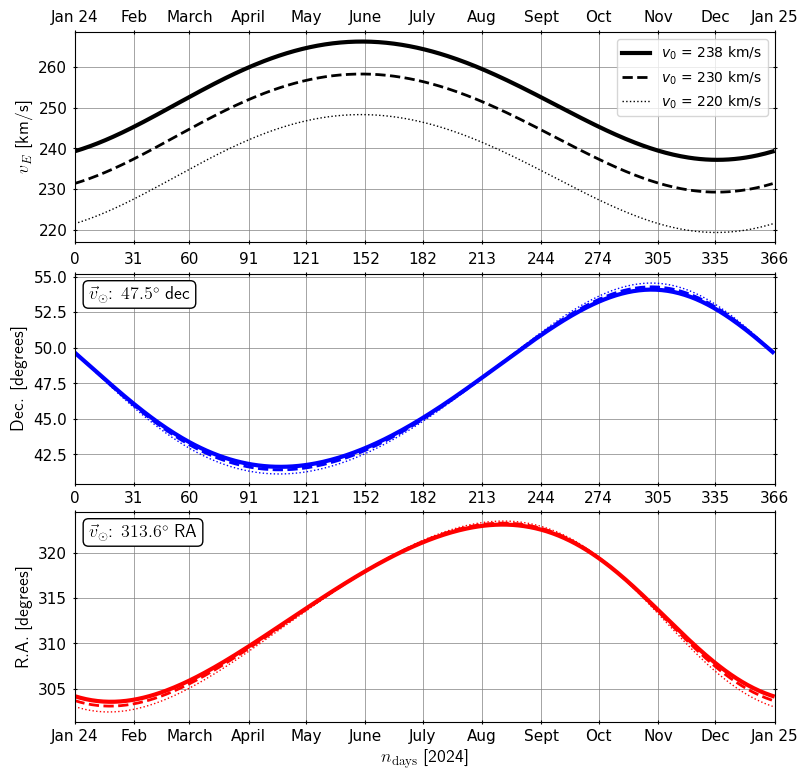

In [12]:
unisize = 3.5
fig = plt.figure(figsize=[2.0*unisize,unisize])
xlim = [0, 366]

# xtix = [30*j for j in range(13)]
xtix = mo_n

ax = fig.add_axes([0,0,1,0.6], xscale='linear', yscale='linear')
ax.set_xticks(xtix, labels=mo_names)
ax.set_xlim(xlim)
ax.tick_params(axis='both', labelsize=11, direction='inout',
               right=True, top=True, labelbottom=True, labeltop=False)
ax.set_xlabel(r'$n_{\rm days}$ [2024]', fontsize=13, usetex=True)
ax.set_ylabel(r'R.A. [degrees]', 
              fontsize=13, usetex=True)

ax.plot(days, d_ras[238], color='red', linewidth=3, linestyle='solid')
ax.plot(days, d_ras[230], color='red', linewidth=2, linestyle='dashed')
ax.plot(days, d_ras[220], color='red', linewidth=1, linestyle='dotted')
# ax.set_ylim([3e-4, 3])
ax.grid(color='gray', linestyle='-', linewidth=0.5)

ax2 = fig.add_axes([0,0.68,1,0.6], xscale='linear', yscale='linear')
ax2.set_xticks(xtix)
ax2.set_xlim(xlim)
ax2.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True, labelbottom=True, labeltop=True)
ax2.set_ylabel(r'Dec. [degrees]', 
               fontsize=13, usetex=True)
ax2.plot(days, d_decs[238], color='blue', linewidth=3, linestyle='solid')
ax2.plot(days, d_decs[230], color='blue', linewidth=2, linestyle='dashed')
ax2.plot(days, d_decs[220], color='blue', linewidth=1, linestyle='dotted')
ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3 = fig.add_axes([0,1.37,1,0.6], xscale='linear', yscale='linear')
ax3.set_xticks(xtix, labels=mo_names)
ax3.set_xlim(xlim)
ax3.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True, labelbottom=False, labeltop=True)
ax3.set_ylabel(r'$v_E$ [km/s]', 
               fontsize=13, usetex=True)
ax3.plot(days, d_speeds[238], color='black', linewidth=3, 
         linestyle='solid', label=r'$v_0$ = 238 km/s')
ax3.plot(days, d_speeds[230], color='black', linewidth=2, 
         linestyle='dashed', label=r'$v_0$ = 230 km/s')
ax3.plot(days, d_speeds[220], color='black', linewidth=1, 
         linestyle='dotted', label=r'$v_0$ = 220 km/s')
ax3.grid(color='gray', linestyle='-', linewidth=0.5)
ax3.legend()

ax.text(0.02, 0.94, r'$\vec{v}_\odot$: $313.6^\circ$ RA', 
        horizontalalignment='left',
        verticalalignment='top', fontsize=13, 
        color='black', backgroundcolor='white',
        bbox=dict(boxstyle='round', fc='w'),
        transform=ax.transAxes, usetex=True)

ax2.text(0.02, 0.94, r'$\vec{v}_\odot$: $47.5^\circ$ dec', 
         horizontalalignment='left',
         verticalalignment='top', fontsize=13, 
         color='black', backgroundcolor='white',
         bbox=dict(boxstyle='round', fc='w'),
         transform=ax2.transAxes, usetex=True)


plt.savefig('EarthPointingDM.pdf', format="pdf", bbox_inches='tight')
fig.show() 



### With right ascension in hours rather than degrees:

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


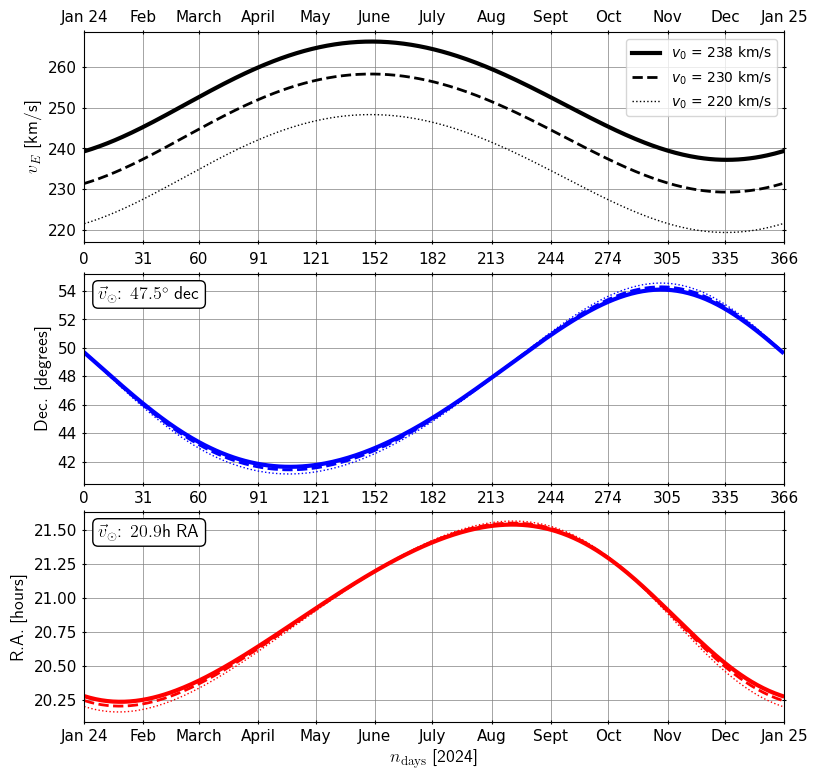

In [13]:
unisize = 3.5
fig = plt.figure(figsize=[2.0*unisize,unisize])
xlim = [0, 366]

# xtix = [30*j for j in range(13)]
xtix = mo_n

ax = fig.add_axes([0,0,1,0.6], xscale='linear', yscale='linear')
ax.set_xticks(xtix, labels=mo_names)
ax.set_xlim(xlim)
ax.set_yticks(np.array([20 + 0.25*j for j in range(13)]))
ax.tick_params(axis='both', labelsize=11, direction='inout',
               right=True, top=True, labelbottom=True, labeltop=False)
ax.set_xlabel(r'$n_{\rm days}$ [2024]', fontsize=13, usetex=True)
ax.set_ylabel(r'R.A. [hours]', 
              fontsize=13, usetex=True)

ax.plot(days, d_ras_h[238], color='red', linewidth=3, linestyle='solid')
ax.plot(days, d_ras_h[230], color='red', linewidth=2, linestyle='dashed')
ax.plot(days, d_ras_h[220], color='red', linewidth=1, linestyle='dotted')
ax.grid(color='gray', linestyle='-', linewidth=0.5)


ax2 = fig.add_axes([0,0.68,1,0.6], xscale='linear', yscale='linear')
ax2.set_xticks(xtix)
ax2.set_yticks(np.array([40 + 2*j for j in range(9)]))
ax2.set_xlim(xlim)
ax2.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True, labelbottom=True, labeltop=True)
ax2.set_ylabel(r'Dec. [degrees]', 
               fontsize=13, usetex=True)
ax2.plot(days, d_decs[238], color='blue', linewidth=3, linestyle='solid')
ax2.plot(days, d_decs[230], color='blue', linewidth=2, linestyle='dashed')
ax2.plot(days, d_decs[220], color='blue', linewidth=1, linestyle='dotted')
ax2.grid(color='gray', linestyle='-', linewidth=0.5)


ax3 = fig.add_axes([0,1.37,1,0.6], xscale='linear', yscale='linear')
ax3.set_xticks(xtix, labels=mo_names)
ax3.set_xlim(xlim)
ax3.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True, labelbottom=False, labeltop=True)
ax3.set_ylabel(r'$v_E$ [km/s]', 
               fontsize=13, usetex=True)
ax3.plot(days, d_speeds[238], color='black', linewidth=3, 
         linestyle='solid', label=r'$v_0$ = 238 km/s')
ax3.plot(days, d_speeds[230], color='black', linewidth=2, 
         linestyle='dashed', label=r'$v_0$ = 230 km/s')
ax3.plot(days, d_speeds[220], color='black', linewidth=1, 
         linestyle='dotted', label=r'$v_0$ = 220 km/s')
ax3.grid(color='gray', linestyle='-', linewidth=0.5)
ax3.legend()


ax.text(0.02, 0.94, r'$\vec{v}_\odot$: $20.9$h RA', 
        horizontalalignment='left',
        verticalalignment='top', fontsize=13, 
        color='black', backgroundcolor='white',
        bbox=dict(boxstyle='round', fc='w'),
        transform=ax.transAxes, usetex=True)

ax2.text(0.02, 0.94, r'$\vec{v}_\odot$: $47.5^\circ$ dec', 
         horizontalalignment='left',
         verticalalignment='top', fontsize=13, 
         color='black', backgroundcolor='white',
         bbox=dict(boxstyle='round', fc='w'),
         transform=ax2.transAxes, usetex=True)


plt.savefig('EarthPointingDM_h.pdf', format="pdf", bbox_inches='tight')
fig.show() 

